# GEOL0069 Week 4 Unsupervised Learning - GitHub Version

## Prerequisite - Installation

In [6]:
!pip install rasterio
!pip install netCDF4

## Prerequisite - Mount Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unsupervised Learning Methods

This section is a basic implementation of the K-means clustering algorithm and Gaussian Mixture Models (GMM). This serves as a foundational understanding and a starting point for applying the algorithm to your specific data analysis tasks.


---



### K-Mean

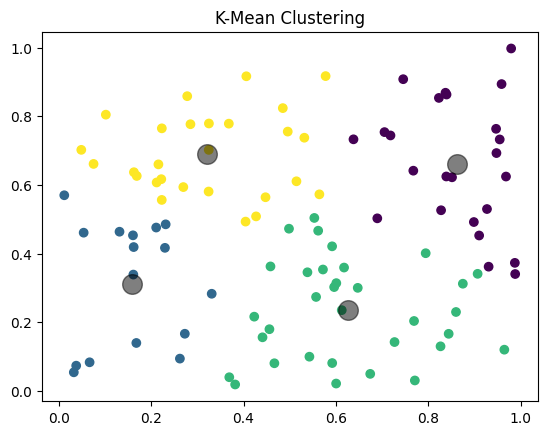

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Sample data
X = np.random.rand(100, 2)

# K-means model
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plotting
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('K-Mean Clustering')
plt.show()

### Gaussian Mixture Models (GMM)

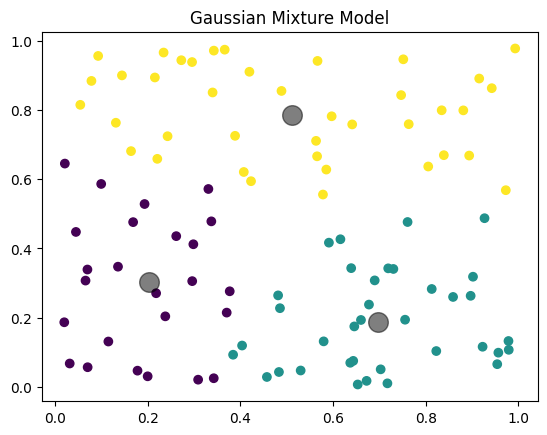

In [9]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Sample data
X = np.random.rand(100, 2)

# GMM model
gmm = GaussianMixture(n_components=3)
gmm.fit(X)
y_gmm = gmm.predict(X)

# Plotting
plt.scatter(X[:, 0], X[:, 1], c=y_gmm, cmap='viridis')
centers = gmm.means_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('Gaussian Mixture Model')
plt.show()

## Application

### Image Classification - Optical Data

Distinguishing between sea ice and leads in Sentinel-2 imagery.

### K-Means Implementation

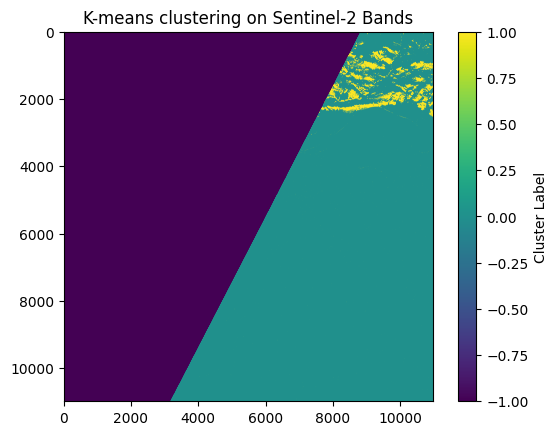

In [10]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Paths to the band images
base_path = "/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/S2A_MSIL1C_20190301T235611_N0207_R116_T01WCU_20190302T014622.SAFE/GRANULE/L1C_T01WCU_A019275_20190301T235610/IMG_DATA/" # You need to specify the path
bands_paths = {
    'B4': base_path + 'T01WCU_20190301T235611_B04.jp2',
    'B3': base_path + 'T01WCU_20190301T235611_B03.jp2',
    'B2': base_path + 'T01WCU_20190301T235611_B02.jp2'
}

# Read and stack the band images
band_data = []
for band in ['B4']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for K-means, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 1))

# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place cluster labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('K-means clustering on Sentinel-2 Bands')
plt.colorbar(label='Cluster Label')
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/S2_K-Mean.jpg", dpi=300)

del kmeans, labels, band_data, band_stack, valid_data_mask, X, labels_image


### GMM Implementation

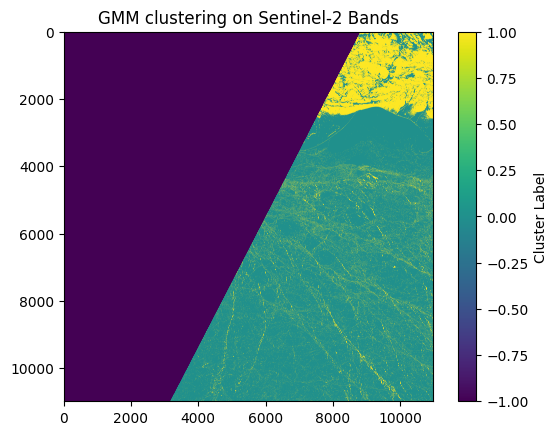

In [13]:
import rasterio
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Paths to the band images
base_path = "/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/S2A_MSIL1C_20190301T235611_N0207_R116_T01WCU_20190302T014622.SAFE/GRANULE/L1C_T01WCU_A019275_20190301T235610/IMG_DATA/" # You need to specify the path
bands_paths = {
    'B4': base_path + 'T01WCU_20190301T235611_B04.jp2',
    'B3': base_path + 'T01WCU_20190301T235611_B03.jp2',
    'B2': base_path + 'T01WCU_20190301T235611_B02.jp2'
}

# Read and stack the band images
band_data = []
for band in ['B4']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for GMM, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 1))

# GMM clustering
gmm = GaussianMixture(n_components=2, random_state=0).fit(X)
labels = gmm.predict(X)

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place GMM labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('GMM clustering on Sentinel-2 Bands')
plt.colorbar(label='Cluster Label')
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/S2_GMM.jpg", dpi=300)

### Altimetry Classification - Altimetry Data
Distinguishing between sea ice and leads in Sentinel-3 altimetry dataset.

### Data Processing

#### Define Subfunctions for Processing Sentinel-3 Altimetry Dataset

In [14]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster

#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    # from scipy import asarray as ar,exp
    from numpy import asarray as ar, exp

    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD


#### Read and Prepare Sentinel-3 Altimetry Dataset for the Classification

In [16]:
# Paths to the altimetry data
path = '/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/'
SAR_file = 'S3A_SR_2_LAN_SI_20190307T005808_20190307T012503_20230527T225016_1614_042_131______LN3_R_NT_005.SEN3'
SAR_data = Dataset(path + SAR_file + '/enhanced_measurement.nc')

SAR_lat = unpack_gpod('lat_20_ku')
SAR_lon = unpack_gpod('lon_20_ku')
waves   = unpack_gpod('waveform_20_ku')
sig_0   = unpack_gpod('sig0_water_20_ku')
RIP     = unpack_gpod('rip_20_ku')
flag    = unpack_gpod('surf_type_class_20_ku')

# Filter out bad data points using criteria (here, lat >= -99999)
find = np.where(SAR_lat >= -99999)
SAR_lat = SAR_lat[find]
SAR_lon = SAR_lon[find]
waves   = waves[find]
sig_0   = sig_0[find]
RIP     = RIP[find]

# Calculate additional features
PP = peakiness(waves)
SSD = calculate_SSD(RIP)

# Convert to numpy arrays (if not already)
sig_0_np = np.array(sig_0)
PP_np    = np.array(PP)
SSD_np   = np.array(SSD)

# Create data matrix
data = np.column_stack((sig_0_np, PP_np, SSD_np))

# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# Remove any rows that contain NaN values
nan_count = np.isnan(data_normalized).sum()
data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)]
mask = ~np.isnan(data_normalized).any(axis=1)
waves_cleaned = np.array(waves)[mask]
flag_cleaned = np.array(flag)[mask]

# Store the valid data
data_cleaned = data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
waves_cleaned = waves_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
flag_cleaned = flag_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]

Running peakiness function...


<ipython-input-14-48fc91f7787c>:62: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


#### K-Mean Implementation

In [17]:
# K-mean clustering
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(data_cleaned)
clusters_kmeans = kmeans.labels_

##### Plot the Mean Waveform and Standard Deviation of Each Class.

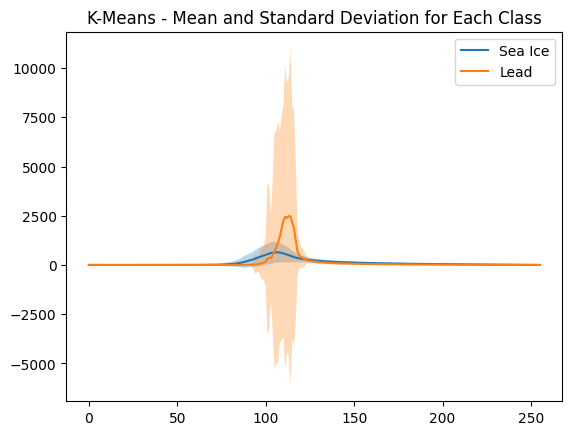

In [18]:
# Calculate the mean and standard deviation for all echoes
mean_ice = np.mean(waves_cleaned[clusters_kmeans==0],axis=0)
std_ice = np.std(waves_cleaned[clusters_kmeans==0], axis=0)

plt.plot(mean_ice, label='Sea Ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)


mean_lead = np.mean(waves_cleaned[clusters_kmeans==1],axis=0)
std_lead = np.std(waves_cleaned[clusters_kmeans==1], axis=0)

plt.plot(mean_lead, label='Lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('K-Means - Mean and Standard Deviation for Each Class')
plt.legend()
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/S3_K-Mean_mean-SD.jpg", dpi=300)

##### Plot the Echos of All Data, Leads, and Sea Ice

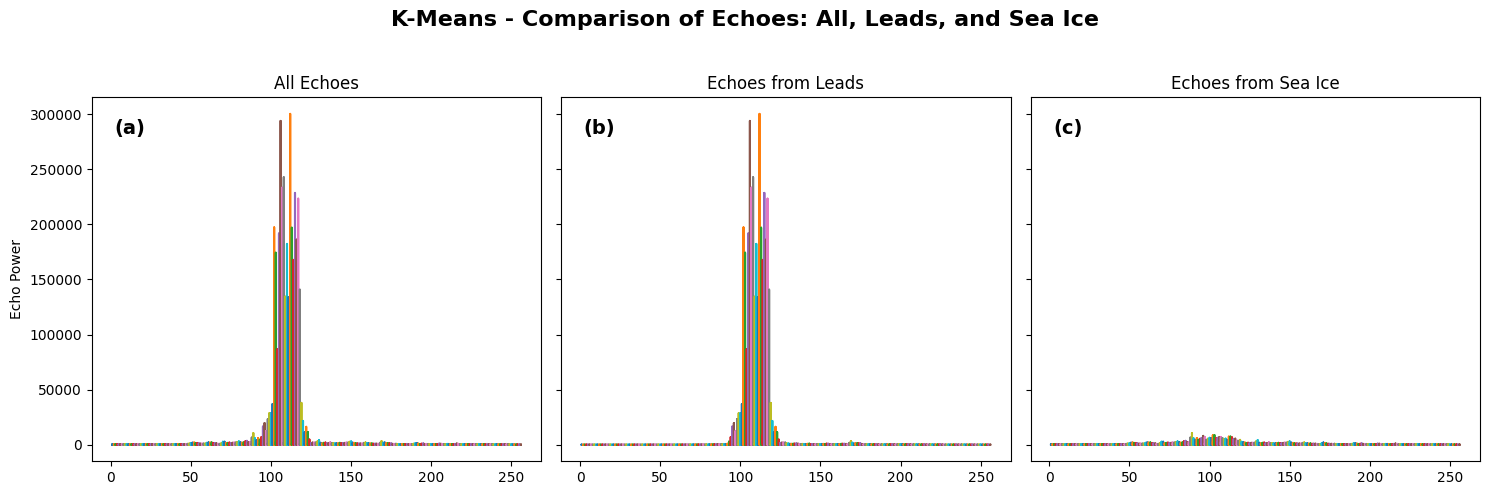

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define x values
x_all = np.stack([np.arange(1, waves_cleaned.shape[1] + 1)] * waves_cleaned.shape[0])
x_leads = np.stack([np.arange(1, waves_cleaned[clusters_kmeans == 1].shape[1] + 1)] * waves_cleaned[clusters_kmeans == 1].shape[0])
x_sea_ice = np.stack([np.arange(1, waves_cleaned[clusters_kmeans == 0].shape[1] + 1)] * waves_cleaned[clusters_kmeans == 0].shape[0])

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Set the figure title
fig.suptitle("K-Means - Comparison of Echoes: All, Leads, and Sea Ice", fontsize=16, fontweight='bold')

# Define subplot labels
subplot_labels = ["(a)", "(b)", "(c)"]

# Plot all echoes
axes[0].plot(x_all, waves_cleaned)
axes[0].set_title("All Echoes")
axes[0].set_ylabel("Echo Power")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes, fontsize=14, fontweight='bold')

# Plot echoes from leads
axes[1].plot(x_leads, waves_cleaned[clusters_kmeans == 1])
axes[1].set_title("Echoes from Leads")
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes, fontsize=14, fontweight='bold')

# Plot echoes from sea ice
axes[2].plot(x_sea_ice, waves_cleaned[clusters_kmeans == 0])
axes[2].set_title("Echoes from Sea Ice")
axes[2].text(0.05, 0.9, subplot_labels[2], transform=axes[2].transAxes, fontsize=14, fontweight='bold')

# Show or save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/S3_K-Mean_Echos.jpg", dpi=300)

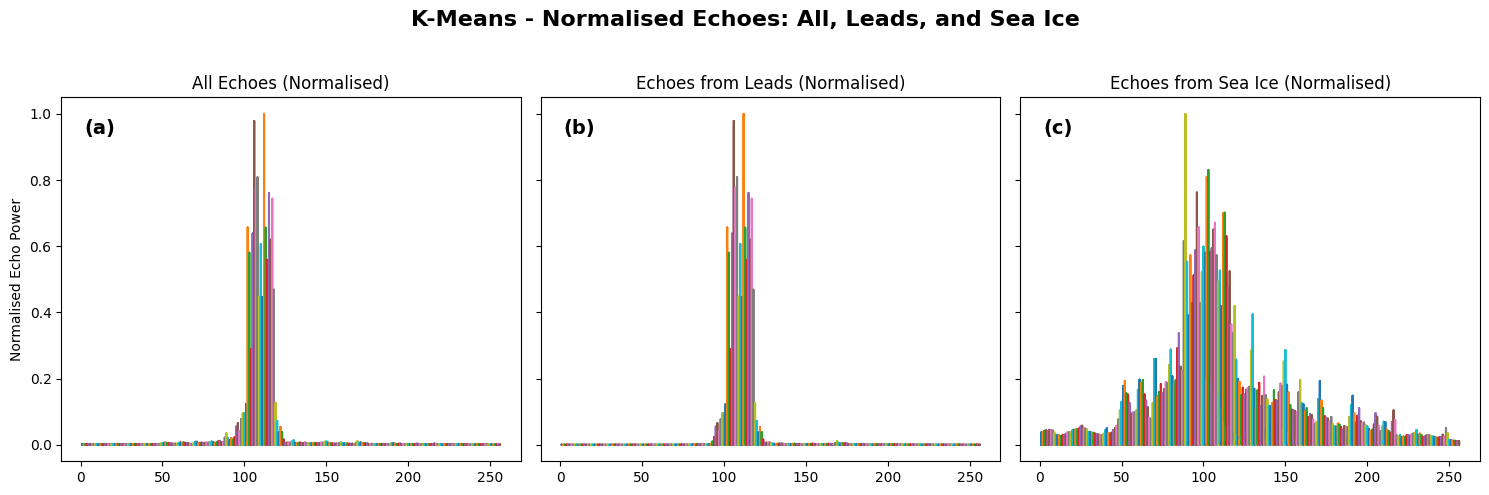

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Define Normalisation Function
def normalise_by_max(data):
    return data / np.max(data)

# Normalise each dataset
waves_cleaned_norm = normalise_by_max(waves_cleaned)
waves_leads_norm = normalise_by_max(waves_cleaned[clusters_kmeans == 1])
waves_sea_ice_norm = normalise_by_max(waves_cleaned[clusters_kmeans == 0])

# Define x values
x_all = np.stack([np.arange(1, waves_cleaned.shape[1] + 1)] * waves_cleaned.shape[0])
x_leads = np.stack([np.arange(1, waves_leads_norm.shape[1] + 1)] * waves_leads_norm.shape[0])
x_sea_ice = np.stack([np.arange(1, waves_sea_ice_norm.shape[1] + 1)] * waves_sea_ice_norm.shape[0])

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Set the figure title
fig.suptitle("K-Means - Normalised Echoes: All, Leads, and Sea Ice", fontsize=16, fontweight='bold')

# Define subplot labels
subplot_labels = ["(a)", "(b)", "(c)"]

# Plot all echoes (normalised by its own max)
axes[0].plot(x_all, waves_cleaned_norm)
axes[0].set_title("All Echoes (Normalised)")
axes[0].set_ylabel("Normalised Echo Power")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes, fontsize=14, fontweight='bold')

# Plot echoes from leads (normalised by its own max)
axes[1].plot(x_leads, waves_leads_norm)
axes[1].set_title("Echoes from Leads (Normalised)")
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes, fontsize=14, fontweight='bold')

# Plot echoes from sea ice (normalised by its own max)
axes[2].plot(x_sea_ice, waves_sea_ice_norm)
axes[2].set_title("Echoes from Sea Ice (Normalised)")
axes[2].text(0.05, 0.9, subplot_labels[2], transform=axes[2].transAxes, fontsize=14, fontweight='bold')

# Show or save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/S3_K-Mean_Normalised_Echos.jpg", dpi=300)

##### Scatter Plots of Clustered Data

<ipython-input-40-4d5fe4d96ae4>:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[0].scatter(data_cleaned[mask, 0], data_cleaned[mask, 1],
<ipython-input-40-4d5fe4d96ae4>:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1].scatter(data_cleaned[mask, 0], data_cleaned[mask, 2],
<ipython-input-40-4d5fe4d96ae4>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as v

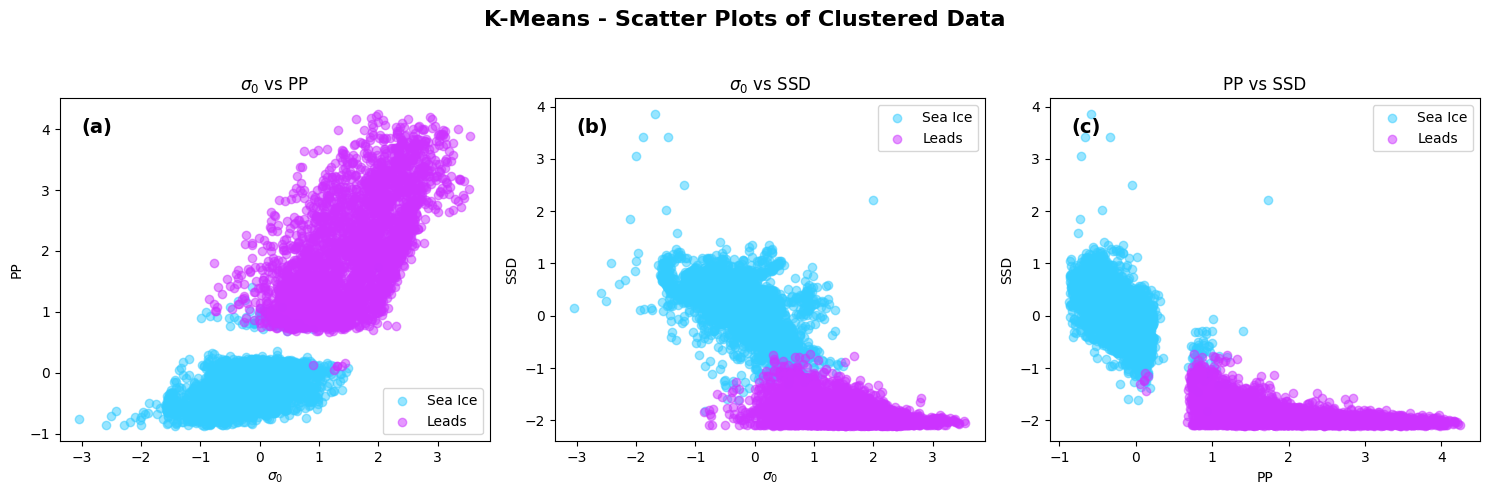

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define cluster labels
cluster_labels = {0: "Sea Ice", 1: "Leads"}

# Apply "cool" colormap for blue-pinkish-purple colors
colors = {0: sns.color_palette("cool", as_cmap=True)(0.2),  # Soft blue
          1: sns.color_palette("cool", as_cmap=True)(0.8)}  # Pinkish-purple

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)

# Set the figure title
fig.suptitle("K-Means - Scatter Plots of Clustered Data", fontsize=16, fontweight='bold')

# Define subplot labels
subplot_labels = ["(a)", "(b)", "(c)"]

# Scatter plot 1: sigma_0 vs PP
for cluster, color in colors.items():
    mask = clusters_kmeans == cluster
    axes[0].scatter(data_cleaned[mask, 0], data_cleaned[mask, 1],
                    c=color, alpha=0.5, label=cluster_labels[cluster])
axes[0].set_xlabel(r"$\sigma_0$")
axes[0].set_ylabel("PP")
axes[0].set_title(r"$\sigma_0$ vs PP")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes, fontsize=14, fontweight='bold')
axes[0].legend()

# Scatter plot 2: sigma_0 vs SSD
for cluster, color in colors.items():
    mask = clusters_kmeans == cluster
    axes[1].scatter(data_cleaned[mask, 0], data_cleaned[mask, 2],
                    c=color, alpha=0.5, label=cluster_labels[cluster])
axes[1].set_xlabel(r"$\sigma_0$")
axes[1].set_ylabel("SSD")
axes[1].set_title(r"$\sigma_0$ vs SSD")
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes, fontsize=14, fontweight='bold')
axes[1].legend()

# Scatter plot 3: PP vs SSD
for cluster, color in colors.items():
    mask = clusters_kmeans == cluster
    axes[2].scatter(data_cleaned[mask, 1], data_cleaned[mask, 2],
                    c=color, alpha=0.5, label=cluster_labels[cluster])
axes[2].set_xlabel("PP")
axes[2].set_ylabel("SSD")
axes[2].set_title("PP vs SSD")
axes[2].text(0.05, 0.9, subplot_labels[2], transform=axes[2].transAxes, fontsize=14, fontweight='bold')
axes[2].legend()

# Show or save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/S3_K-Mean_Scatter_Plot.jpg", dpi=300)


#### GMM Implementation

In [22]:
# GMM clustering
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_cleaned)
clusters_gmm = gmm.predict(data_cleaned)

##### Plot the Mean Waveform and Standard Deviation of Each Class.

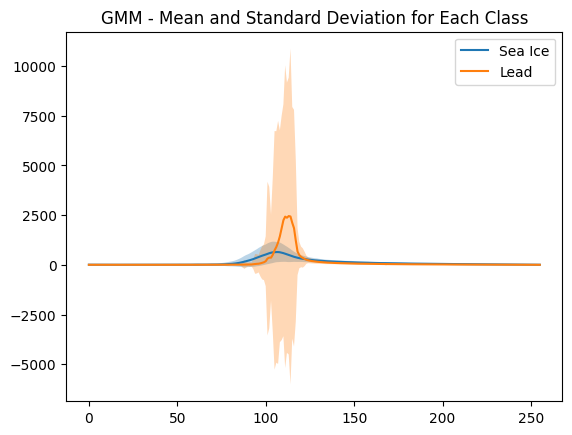

In [23]:
# Calculate the mean and standard deviation for all echoes
mean_ice = np.mean(waves_cleaned[clusters_gmm==0],axis=0)
std_ice = np.std(waves_cleaned[clusters_gmm==0], axis=0)

plt.plot(mean_ice, label='Sea Ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)


mean_lead = np.mean(waves_cleaned[clusters_gmm==1],axis=0)
std_lead = np.std(waves_cleaned[clusters_gmm==1], axis=0)

plt.plot(mean_lead, label='Lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('GMM - Mean and Standard Deviation for Each Class')
plt.legend()
plt.savefig("/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/S3_GMM_mean-SD.jpg", dpi=300)

##### Plot the Echos of All Data, Leads, and Sea Ice

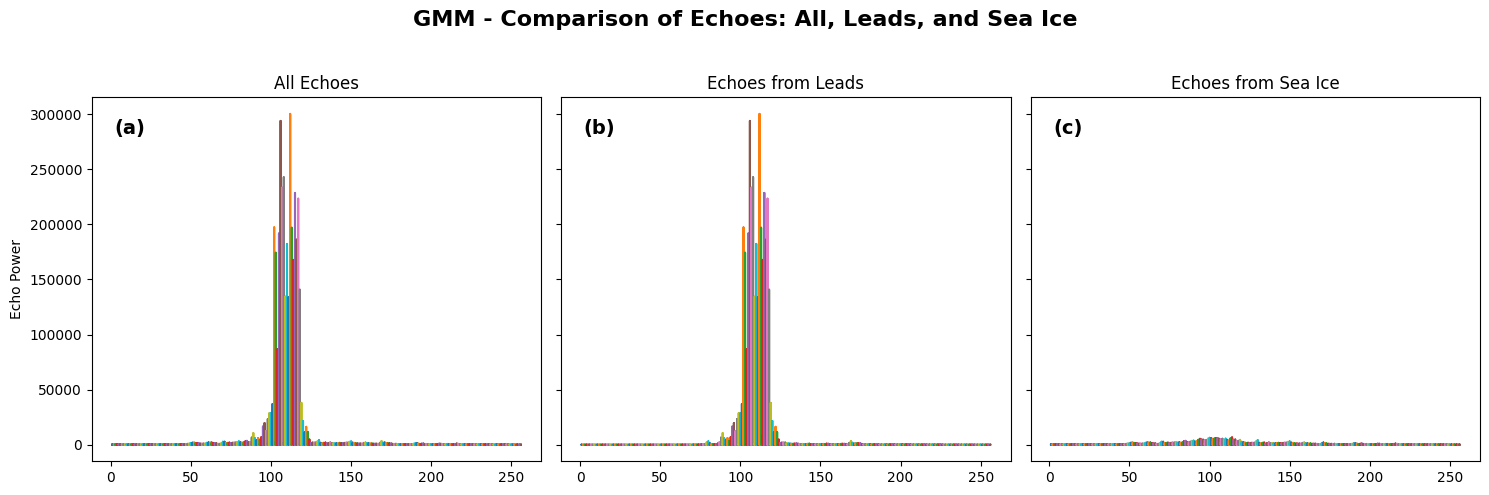

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define x values
x_all = np.stack([np.arange(1, waves_cleaned.shape[1] + 1)] * waves_cleaned.shape[0])
x_leads = np.stack([np.arange(1, waves_cleaned[clusters_gmm == 1].shape[1] + 1)] * waves_cleaned[clusters_gmm == 1].shape[0])
x_sea_ice = np.stack([np.arange(1, waves_cleaned[clusters_gmm == 0].shape[1] + 1)] * waves_cleaned[clusters_gmm == 0].shape[0])

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Set the figure title
fig.suptitle("GMM - Comparison of Echoes: All, Leads, and Sea Ice", fontsize=16, fontweight='bold')

# Define subplot labels
subplot_labels = ["(a)", "(b)", "(c)"]

# Plot all echoes
axes[0].plot(x_all, waves_cleaned)
axes[0].set_title("All Echoes")
axes[0].set_ylabel("Echo Power")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes, fontsize=14, fontweight='bold')

# Plot echoes from leads
axes[1].plot(x_leads, waves_cleaned[clusters_gmm == 1])
axes[1].set_title("Echoes from Leads")
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes, fontsize=14, fontweight='bold')

# Plot echoes from sea ice
axes[2].plot(x_sea_ice, waves_cleaned[clusters_gmm == 0])
axes[2].set_title("Echoes from Sea Ice")
axes[2].text(0.05, 0.9, subplot_labels[2], transform=axes[2].transAxes, fontsize=14, fontweight='bold')

# Show or save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/S3_GMM_Echos.jpg", dpi=300)

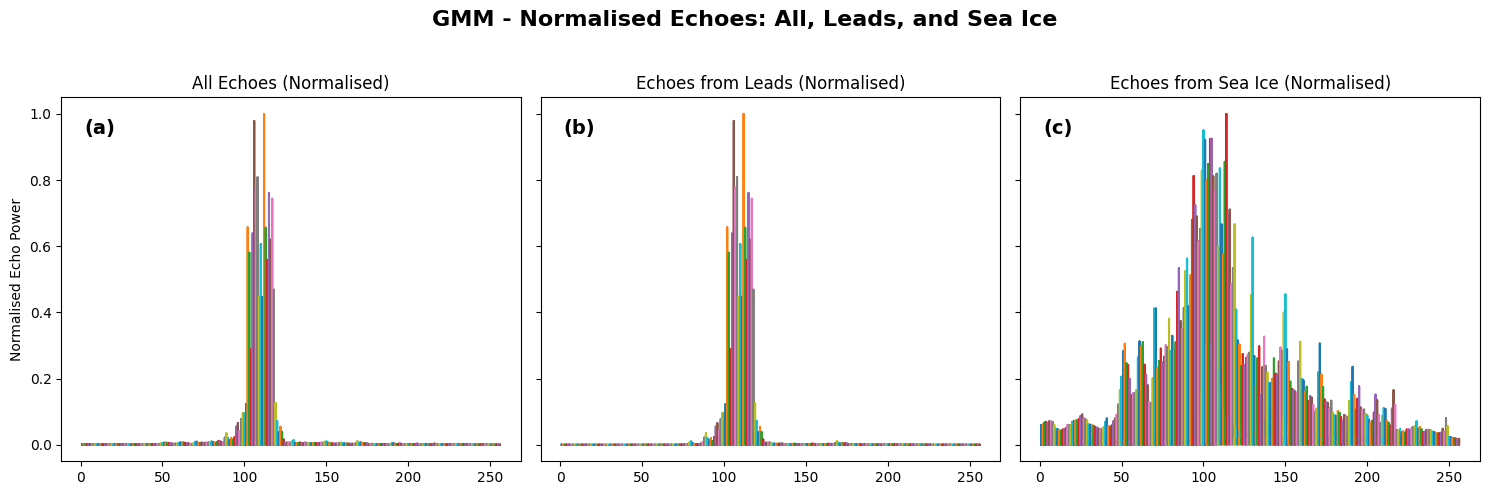

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Normalisation Function
def normalise_by_max(data):
    return data / np.max(data)

# Normalise each dataset
waves_cleaned_norm = normalise_by_max(waves_cleaned)
waves_leads_norm = normalise_by_max(waves_cleaned[clusters_gmm == 1])
waves_sea_ice_norm = normalise_by_max(waves_cleaned[clusters_gmm == 0])

# Define x values
x_all = np.stack([np.arange(1, waves_cleaned.shape[1] + 1)] * waves_cleaned.shape[0])
x_leads = np.stack([np.arange(1, waves_leads_norm.shape[1] + 1)] * waves_leads_norm.shape[0])
x_sea_ice = np.stack([np.arange(1, waves_sea_ice_norm.shape[1] + 1)] * waves_sea_ice_norm.shape[0])

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Set the figure title
fig.suptitle("GMM - Normalised Echoes: All, Leads, and Sea Ice", fontsize=16, fontweight='bold')

# Define subplot labels
subplot_labels = ["(a)", "(b)", "(c)"]

# Plot all echoes (normalised by its own max)
axes[0].plot(x_all, waves_cleaned_norm)
axes[0].set_title("All Echoes (Normalised)")
axes[0].set_ylabel("Normalised Echo Power")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes, fontsize=14, fontweight='bold')

# Plot echoes from leads (normalised by its own max)
axes[1].plot(x_leads, waves_leads_norm)
axes[1].set_title("Echoes from Leads (Normalised)")
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes, fontsize=14, fontweight='bold')

# Plot echoes from sea ice (normalised by its own max)
axes[2].plot(x_sea_ice, waves_sea_ice_norm)
axes[2].set_title("Echoes from Sea Ice (Normalised)")
axes[2].text(0.05, 0.9, subplot_labels[2], transform=axes[2].transAxes, fontsize=14, fontweight='bold')

# Show or save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL/Week_4/Unsupervised Learning/S3_GMM_Normalised_Echos.jpg", dpi=300)

##### Scatter Plots of Clustered Data

<ipython-input-41-d53434655507>:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[0].scatter(data_cleaned[mask, 0], data_cleaned[mask, 1],
<ipython-input-41-d53434655507>:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1].scatter(data_cleaned[mask, 0], data_cleaned[mask, 2],
<ipython-input-41-d53434655507>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as v

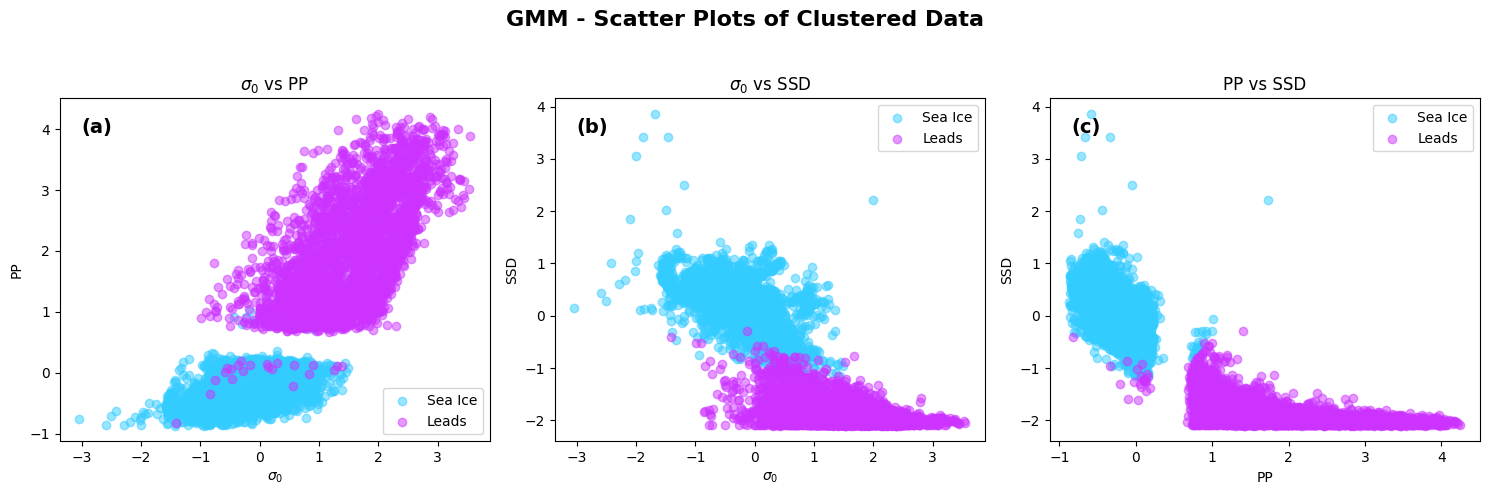

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define cluster labels
cluster_labels = {0: "Sea Ice", 1: "Leads"}

# Apply "cool" colormap for blue-pinkish-purple colors
colors = {0: sns.color_palette("cool", as_cmap=True)(0.2),  # Soft blue
          1: sns.color_palette("cool", as_cmap=True)(0.8)}  # Pinkish-purple

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)

# Set the figure title
fig.suptitle("GMM - Scatter Plots of Clustered Data", fontsize=16, fontweight='bold')

# Define subplot labels
subplot_labels = ["(a)", "(b)", "(c)"]

# Scatter plot 1: sigma_0 vs PP
for cluster, color in colors.items():
    mask = clusters_gmm == cluster
    axes[0].scatter(data_cleaned[mask, 0], data_cleaned[mask, 1],
                    c=color, alpha=0.5, label=cluster_labels[cluster])
axes[0].set_xlabel(r"$\sigma_0$")
axes[0].set_ylabel("PP")
axes[0].set_title(r"$\sigma_0$ vs PP")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes, fontsize=14, fontweight='bold')
axes[0].legend()

# Scatter plot 2: sigma_0 vs SSD
for cluster, color in colors.items():
    mask = clusters_gmm == cluster
    axes[1].scatter(data_cleaned[mask, 0], data_cleaned[mask, 2],
                    c=color, alpha=0.5, label=cluster_labels[cluster])
axes[1].set_xlabel(r"$\sigma_0$")
axes[1].set_ylabel("SSD")
axes[1].set_title(r"$\sigma_0$ vs SSD")
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes, fontsize=14, fontweight='bold')
axes[1].legend()

# Scatter plot 3: PP vs SSD
for cluster, color in colors.items():
    mask = clusters_gmm == cluster
    axes[2].scatter(data_cleaned[mask, 1], data_cleaned[mask, 2],
                    c=color, alpha=0.5, label=cluster_labels[cluster])
axes[2].set_xlabel("PP")
axes[2].set_ylabel("SSD")
axes[2].set_title("PP vs SSD")
axes[2].text(0.05, 0.9, subplot_labels[2], transform=axes[2].transAxes, fontsize=14, fontweight='bold')
axes[2].legend()

# Show or save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL/Week_4/Unsupervised LearningS3_GMM_Scatter_Plot.jpg", dpi=300)


## Waveform Alignment Using Cross-Correlation
Due to the shifting of the sea ice, the altimetry data would also experience a positional shift. In order to produce a scientifically meaningful result, the altimetry data need to be aligned before averaging. In this example, the altimetry data was aligned by the peak using cross-correlation.

### K-Mean

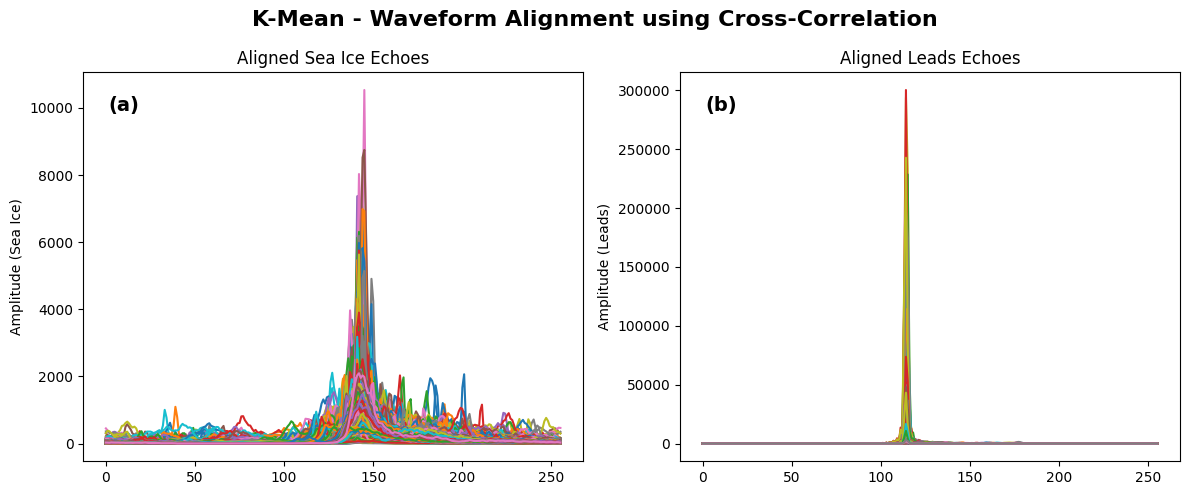

In [42]:
from scipy.signal import correlate

# Extract the sea ice and leads dataset
sea_ice_waves = waves_cleaned[clusters_kmeans == 0]
leads_waves = waves_cleaned[clusters_kmeans == 1]

# Define a function to align waves using cross-correlation
def align_waves(waves):
    # Find the reference point (e.g., the peak)
    reference_point_index = np.argmax(np.mean(waves, axis=0))
    # Calculate cross-correlation with the reference point
    aligned_waves = []
    for wave in waves:
        correlation = correlate(wave, waves[0])
        shift = len(wave) - np.argmax(correlation)
        aligned_wave = np.roll(wave, shift)
        aligned_waves.append(aligned_wave)
    return np.array(aligned_waves)

# Align both datasets
KMean_aligned_sea_ice_waves = align_waves(sea_ice_waves)
KMean_aligned_leads_waves = align_waves(leads_waves)


# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Set the figure title
fig.suptitle("K-Mean - Waveform Alignment using Cross-Correlation", fontsize=16, fontweight='bold')

# Define subplot labels
subplot_labels = ["(a)", "(b)"]

# Plot aligned sea ice echoes
for aligned_wave in KMean_aligned_sea_ice_waves:
    axes[0].plot(aligned_wave)
axes[0].set_title("Aligned Sea Ice Echoes")
axes[0].set_ylabel("Amplitude (Sea Ice)")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes, fontsize=14, fontweight='bold')

# Plot aligned leads echoes
for aligned_wave in KMean_aligned_leads_waves:
    axes[1].plot(aligned_wave)
axes[1].set_title("Aligned Leads Echoes")
axes[1].set_ylabel("Amplitude (Leads)")
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes, fontsize=14, fontweight='bold')

# Show or save the figure
plt.tight_layout()
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL0069_AI4EO/Week_4/Unsupervised_Learning/S3_K-Mean_Align_Wave.jpg", dpi=300)

### GMM

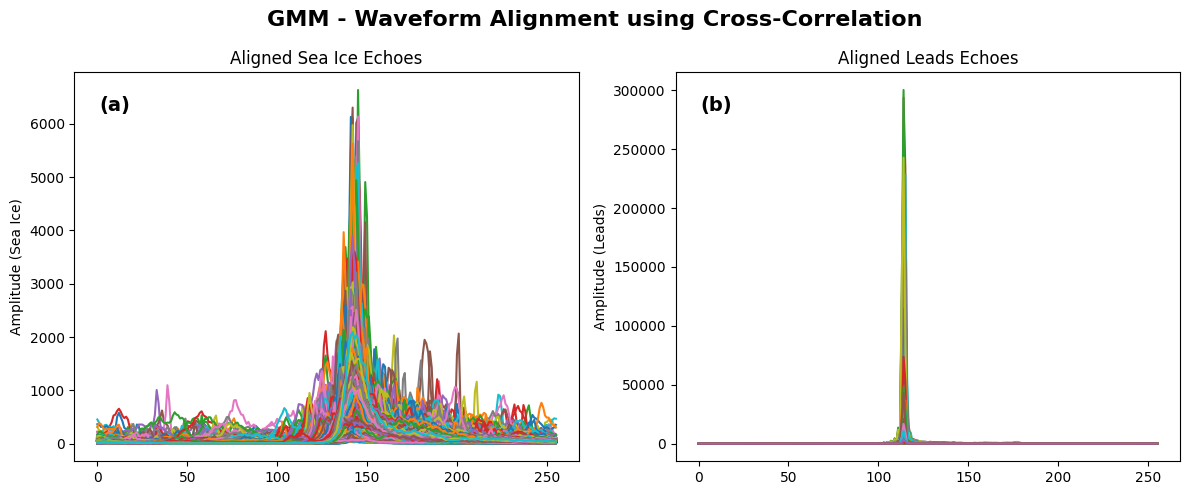

In [43]:
from scipy.signal import correlate

# Extract the sea ice and leads dataset
sea_ice_waves = waves_cleaned[clusters_gmm == 0]
leads_waves = waves_cleaned[clusters_gmm == 1]

# Define a function to align waves using cross-correlation
def align_waves(waves):
    # Find the reference point (e.g., the peak)
    reference_point_index = np.argmax(np.mean(waves, axis=0))
    # Calculate cross-correlation with the reference point
    aligned_waves = []
    for wave in waves:
        correlation = correlate(wave, waves[0])
        shift = len(wave) - np.argmax(correlation)
        aligned_wave = np.roll(wave, shift)
        aligned_waves.append(aligned_wave)
    return np.array(aligned_waves)

# Align both datasets
GMM_aligned_sea_ice_waves = align_waves(sea_ice_waves)
GMM_aligned_leads_waves = align_waves(leads_waves)


# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Set the figure title
fig.suptitle("GMM - Waveform Alignment using Cross-Correlation", fontsize=16, fontweight='bold')

# Define subplot labels
subplot_labels = ["(a)", "(b)"]

# Plot aligned sea ice echoes
for aligned_wave in GMM_aligned_sea_ice_waves:
    axes[0].plot(aligned_wave)
axes[0].set_title("Aligned Sea Ice Echoes")
axes[0].set_ylabel("Amplitude (Sea Ice)")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes, fontsize=14, fontweight='bold')

# Plot aligned leads echoes
for aligned_wave in GMM_aligned_leads_waves:
    axes[1].plot(aligned_wave)
axes[1].set_title("Aligned Leads Echoes")
axes[1].set_ylabel("Amplitude (Leads)")
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes, fontsize=14, fontweight='bold')

# Show or save the figure
plt.tight_layout()
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL0069_AI4EO/Week_4/Unsupervised_Learning/S3_GMM_Align_Wave.jpg", dpi=300)

# Final Comparison
- Classify the echoes in leads and sea ice and produce an average echo shape as well as standard deviation for these two classes
- Quantify your echo classification against the ESA official classification using a confusion matrix

### Average Echo Shape and Standard Deviation

#### K-Mean

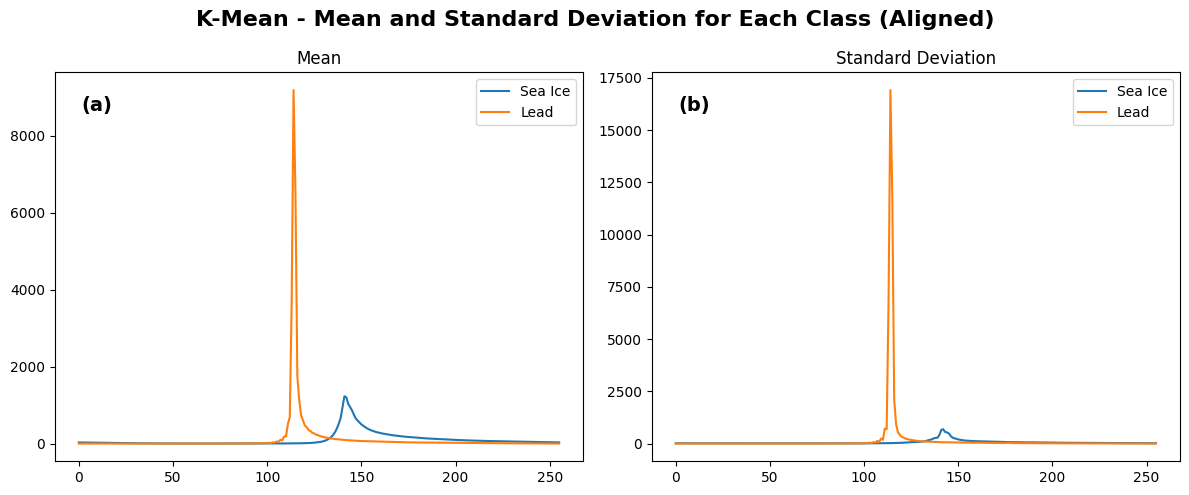

In [44]:
# Calculate mean and standard deviation for aligned sea ice and lead
mean_ice = np.mean(KMean_aligned_sea_ice_waves,axis=0)
std_ice = np.std(KMean_aligned_sea_ice_waves, axis=0)
mean_lead = np.mean(KMean_aligned_leads_waves,axis=0)
std_lead = np.std(KMean_aligned_leads_waves, axis=0)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Set the figure title
fig.suptitle("K-Mean - Mean and Standard Deviation for Each Class (Aligned)", fontsize=16, fontweight='bold')

# Define subplot labels
subplot_labels = ["(a)", "(b)"]

# Plot the mean of sea ice and lead
axes[0].plot(mean_ice, label='Sea Ice')
axes[0].plot(mean_lead, label='Lead')
axes[0].set_title("Mean")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes, fontsize=14, fontweight='bold')
axes[0].legend()

# Plot the standard deviation of sea ice and lead
axes[1].plot(std_ice, label='Sea Ice')
axes[1].plot(std_lead, label='Lead')
axes[1].set_title("Standard Deviation")
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes, fontsize=14, fontweight='bold')
axes[1].legend()

# Show or save the figure
plt.tight_layout()
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL0069_AI4EO/Week_4/Unsupervised_Learning/S3_K-Mean_aligned_mean-SD.jpg", dpi=300)

#### GMM

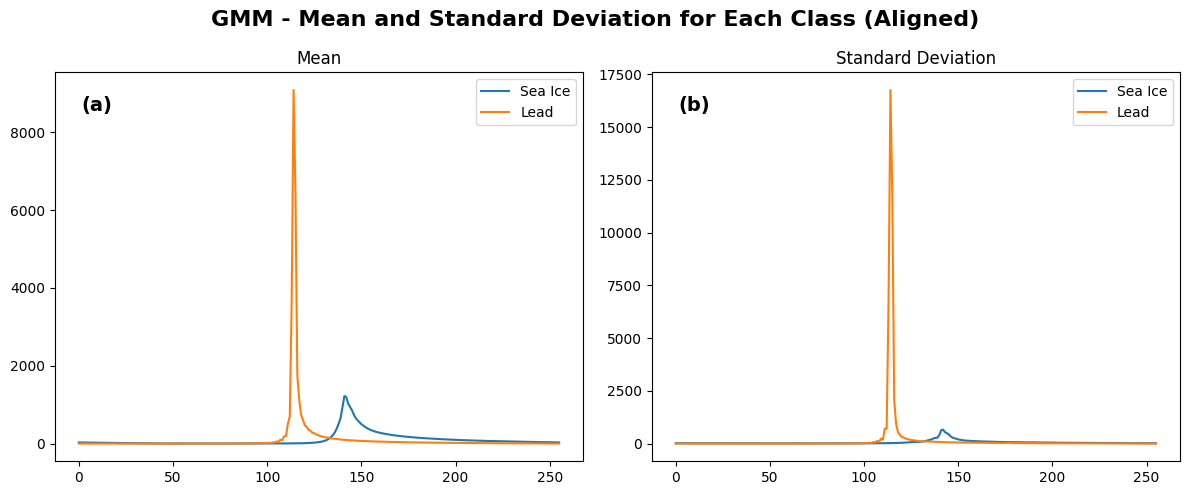

In [45]:
# Calculate mean and standard deviation for aligned sea ice and lead
mean_ice = np.mean(GMM_aligned_sea_ice_waves,axis=0)
std_ice = np.std(GMM_aligned_sea_ice_waves, axis=0)
mean_lead = np.mean(GMM_aligned_leads_waves,axis=0)
std_lead = np.std(GMM_aligned_leads_waves, axis=0)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Set the figure title
fig.suptitle("GMM - Mean and Standard Deviation for Each Class (Aligned)", fontsize=16, fontweight='bold')

# Define subplot labels
subplot_labels = ["(a)", "(b)"]

# Plot the mean of sea ice and lead
axes[0].plot(mean_ice, label='Sea Ice')
axes[0].plot(mean_lead, label='Lead')
axes[0].set_title("Mean")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes, fontsize=14, fontweight='bold')
axes[0].legend()

# Plot the standard deviation of sea ice and lead
axes[1].plot(std_ice, label='Sea Ice')
axes[1].plot(std_lead, label='Lead')
axes[1].set_title("Standard Deviation")
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes, fontsize=14, fontweight='bold')
axes[1].legend()

# Show or save the figure
plt.tight_layout()
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL0069_AI4EO/Week_4/Unsupervised_Learning/S3_GMM_aligned_mean-SD.jpg", dpi=300)

### Compare with ESA data

#### K-Mean and GMM


K-Mean Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      8878
         1.0       1.00      0.98      0.99      3317

    accuracy                           0.99     12195
   macro avg       0.99      0.99      0.99     12195
weighted avg       0.99      0.99      0.99     12195

-----------------------

GMM_Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8878
         1.0       0.99      0.99      0.99      3317

    accuracy                           1.00     12195
   macro avg       1.00      1.00      1.00     12195
weighted avg       1.00      1.00      1.00     12195



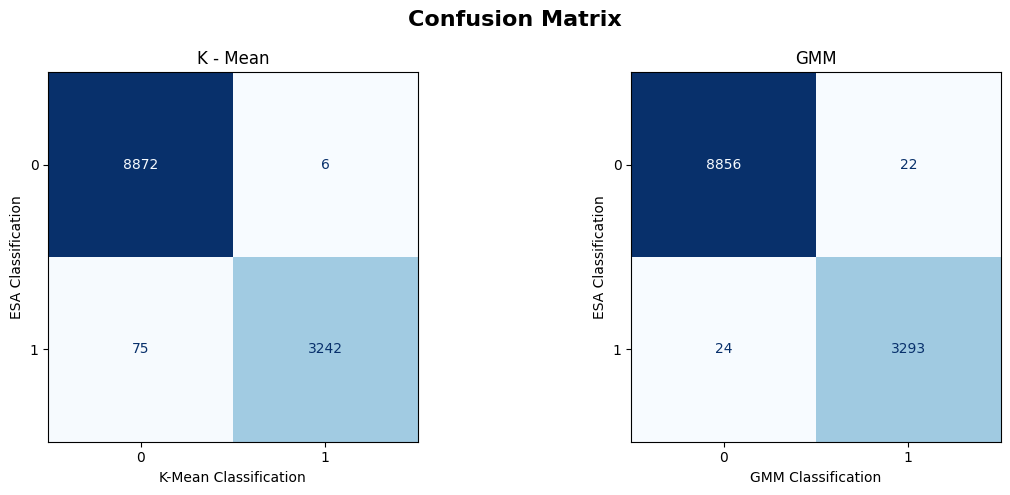

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# In the ESA dataset, sea ice = 1 and lead = 2
# Therefore, we need to subtract 1 from it so our predicted labels are comparable with the official product labels.
flag_cleaned_modified = flag_cleaned - 1

true_labels = flag_cleaned_modified   # true labels from the ESA dataset
predicted_kmeans = clusters_kmeans    # predicted labels from K-Mean method
predicted_gmm = clusters_gmm          # predicted labels from GMM method

# Compute confusion matrix
KMean_conf_matrix = confusion_matrix(true_labels, predicted_kmeans)
GMM_conf_matrix = confusion_matrix(true_labels, predicted_gmm)

# Compute classification report
KMean_class_report = classification_report(true_labels, predicted_kmeans)
GMM_class_report = classification_report(true_labels, predicted_gmm)

# Print classification report
print("\nK-Mean Classification Report:")
print(KMean_class_report)
print("-----------------------")
print("\nGMM_Classification Report:")
print(GMM_class_report)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Set the figure title
fig.suptitle("Confusion Matrix", fontsize=16, fontweight='bold')

# K-Means Confusion Matrix
disp_kmeans = ConfusionMatrixDisplay(confusion_matrix=KMean_conf_matrix)
disp_kmeans.plot(cmap="Blues", values_format="d", ax=axes[0], colorbar=False)
axes[0].set_title("K - Mean")
axes[0].set_xlabel("K-Mean Classification")
axes[0].set_ylabel("ESA Classification")

# GMM Confusion Matrix
disp_gmm = ConfusionMatrixDisplay(confusion_matrix=GMM_conf_matrix)
disp_gmm.plot(cmap="Blues", values_format="d", ax=axes[1], colorbar=False)
axes[1].set_title("GMM")
axes[1].set_xlabel("GMM Classification")
axes[1].set_ylabel("ESA Classification")

# Show or save the figure
plt.tight_layout()
plt.show()
#plt.savefig("/content/drive/MyDrive/GEOL0069_AI4EO/Week_4/Unsupervised_Learning/KMean-GMM_Conf_Matrix.jpg", dpi=300)